In [8]:
# importing libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
!pip install openpyxl

In [3]:
# importing data 

# define the path to the excel file 
file_path=r'C:\Users\sneha\Documents\prediction_data.xlsx'

# define the sheet name to use the data from
sheet_name='Sheet1'

# read the data from the specified sheet into a pandas dataframe
data=pd.read_excel(file_path,sheet_name=sheet_name)

data.head()


,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11098-MAD,Female,30,Yes,Madhya Pradesh,0,31,Deal 1,True,No,...,Bank Withdrawal,95.099998,6683.399902,0.00,0,631.719971,7315.120117,Stayed,Others,Others
1,11114-PUN,Male,51,No,Punjab,5,9,Deal 5,True,No,...,Bank Withdrawal,49.150002,169.050003,0.00,10,122.370003,301.420013,Churned,Competitor,Competitor had better devices
2,11167-WES,Female,43,Yes,West Bengal,3,28,Deal 1,True,Yes,...,Bank Withdrawal,116.050003,8297.500000,42.57,110,1872.979980,10237.910156,Stayed,Others,Others
3,11179-MAH,Male,35,No,Maharashtra,10,12,NaN,True,No,...,Credit Card,84.400002,5969.299805,0.00,0,219.389999,6188.689941,Stayed,Others,Others
4,11180-TAM,Male,75,Yes,Tamil Nadu,12,27,Deal 2,True,No,...,Credit Card,72.599998,4084.350098,0.00,140,332.079987,4556.430176,Stayed,Others,Others


In [6]:
# data processing
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

# cust_id is just a num assigned to each customer i don't want my model to consider this colm as a predictive variable.
# churn_reason,churn_cat are targeted colm.

# List of columns to be label encoded
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
] 
# when we consider a ml model like random-forest these are very bad at reading cat cols.
# thats why converting categorical colms to numerical cols .

# encode cat colm except targeted colm bcoz churn will be converted into 0 and stayed to 1 ,it's not a problem at all but in general practice whatever we are trying to predict we should want it as 1.  
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# label_encoder first sorts the value alphabetically, for ex gender has 2 values male,female so its first sort the values i.e female comes first and assigns the value 0 to it .

# Manually encode the target variable 'Customer_Status'
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

# Split data into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Confusion Matrix:
[[783  64]
 [126 229]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       847
           1       0.78      0.65      0.71       355

    accuracy                           0.84      1202
   macro avg       0.82      0.78      0.80      1202
weighted avg       0.84      0.84      0.84      1202



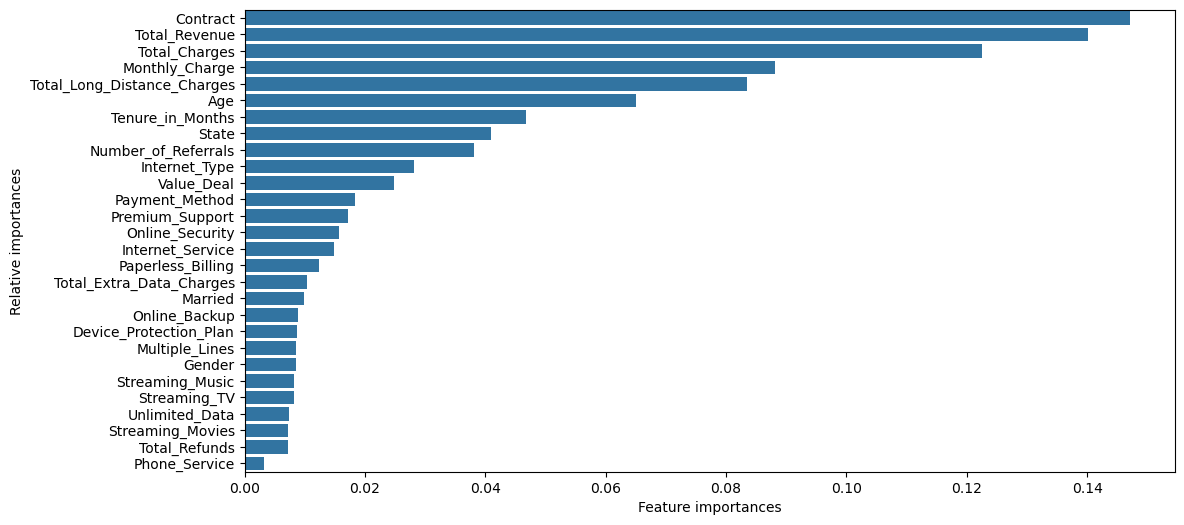

In [11]:
# training our model
rf=RandomForestClassifier(n_estimators=100,random_state=42)

rf.fit(X_train,y_train)

# make predictions
y_pred=rf.predict(X_test)

# Evaluate the model
print('Confusion Matrix:')
print(confusion_matrix(y_test,y_pred))
print('\nClassification Report:')
print(classification_report(y_test,y_pred))

# feature selection using feature importance 
importances=rf.feature_importances_
indices=np.argsort(importances)[::-1]

# plot the feature importance
plt.figure(figsize=(12,6))
sns.barplot(x=importances[indices],y=X.columns[indices])
plt.xlabel("Feature importances")
plt.ylabel("Relative importances")
plt.show()

In [12]:
# each row of the colm matrix represents the actual class whle each col represents predictive class.
# 0 is for stayed

In [13]:
# in general practice, we can remove all features which have importance less than 0.01.

In [16]:
# Define the path to the Joiner Data Excel file
file_path = r'C:\Users\sneha\Documents\prediction_data.xlsx'

# Define the sheet name to read data from
sheet_name = 'Sheet2'

# Read the data from the specified sheet into a pandas DataFrame
new_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the fetched data
print(new_data.head())

# Retain the original DataFrame to preserve unencoded columns
original_data = new_data.copy()

# Retain the Customer_ID column
customer_ids = new_data['Customer_ID']

# Drop columns that won't be used for prediction in the encoded DataFrame
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

# Encode categorical variables using the saved label encoders
for column in new_data.select_dtypes(include=['object']).columns:
  new_data[column] = label_encoders[column].transform(new_data[column])


# Make predictions
new_predictions = rf.predict(new_data)

# Add predictions to the original DataFrame
original_data['Customer_Status_Predicted'] = new_predictions

# Filter the DataFrame to include only records predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]

# Save the results
original_data.to_csv(r"C:\Users\sneha\Documents\Predictions.csv", index=False)



  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   11751-TAM  Female   18      No   Tamil Nadu                    5   
1   12056-WES    Male   27      No  West Bengal                    2   
2   12136-RAJ  Female   25     Yes    Rajasthan                    2   
3   12257-ASS  Female   39      No        Assam                    9   
4   12340-DEL  Female   51     Yes        Delhi                    0   

   Tenure_in_Months Value_Deal  Phone_Service Multiple_Lines  ...  \
0                 7     Deal 5          False             No  ...   
1                20        NaN           True             No  ...   
2                35        NaN           True             No  ...   
3                 1        NaN           True             No  ...   
4                10        NaN           True             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      24.299999     38.450001           0.0   
1  Bank Withdrawal    